# Sparse Precision Matrix

In the field of data analysis and machine learning, estimating the precision matrix has always been an important problem. Traditional optimization problems based on Gaussian graphical models often use the loss function $L^{\text{GGM}}(\Omega)=\text{tr}(S\Omega)-\log\det \Omega$ for solving. However, this optimization problem is not strongly convex and smooth, and may require additional steps and conditions to achieve the best results. Moreover, this method is essentially applicable only to multivariate Gaussian random vectors.

However, in practical applications, the sample data often does not completely conform to the assumption of multivariate Gaussian distribution. Here are some more specific examples.

- Social Network Analysis: Social networks, where nodes represent individuals and edges depict their social connections, often exhibit complex non-Gaussian distributions, such as power-law distributions.

- Financial Market Networks: Financial market networks, with nodes representing different assets and edges denoting their interactions, typically demonstrate nonlinearity and non-Gaussian characteristics.

- Large-scale Recommendation Systems: Graph-based recommendation systems, capturing user-item interactions, often involve complex distributions that deviate from multivariate Gaussian assumptions. These distributions can include long-tailed distributions, indicating that some items have significantly higher frequencies than others in user behavior data.

In such cases, we would like to obtain a more general loss function for estimating the precision matrix. Since Since $\Sigma^*\Omega^*=1$, where $\Sigma^*$ and $\Omega^*$ are the true values of the covariance matrix and precision matrix respectively, we can consider the discrepancy between $\Sigma\Omega$ and the identity matrix $I_{p\times p}$ in some sense, similar to [[1]](#refer-anchor-1), where $\Sigma$ is the sample covariance matrix.

Here, we consider to minimize another loss function for learning sparse precision matrix, i.e., 
$$
\begin{aligned}
\arg\min & L(\Omega)=\| {\Sigma}{\Omega} - \mathbf{I}_{p\times p} \|_F
\\
&\text{subject to:} \; 
\Omega \in \mathcal{S}^{++} \\
&\qquad\qquad\| \Omega \|_0 \leq s \\
\end{aligned}
$$
where $\| \Omega \|_0$ is the number of non-zero entries on upper-diagonal matrix of $\Omega$ and $\mathcal{S}^{++}$ is the space of symmetric positive definite matrix. 

In [1]:
from scope import GraspSolver, ScopeSolver
import jax.numpy as jnp
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as la

First, we define the loss function $L(\Omega)$ mentioned above. In this function, since the parameters accepted by `scope` need to be in vector form, we input a vector composed of the upper triangular part of matrix $\Omega$ and then restore it to a matrix within the function.
Furthermore, we use the cvxpy package to define a solver with symmetric positive definite conditions.

In [2]:
def graphical_loss(params, sample_covariance_matrix):
    p = sample_covariance_matrix.shape[0]
    Omega = jnp.zeros((p, p))
    Omega = Omega.at[np.triu_indices(p)].set(params)
    Omega = jnp.where(Omega, Omega, Omega.T)
    return jnp.linalg.norm(jnp.matmul(sample_covariance_matrix, Omega) - np.diag(np.ones(p)), ord='fro')



def convex_solver_cvxpy(
    loss_fn,
    value_and_grad,
    params,
    optim_variable_set,
    data,
):
    data = np.squeeze(np.array(data))
    p = data.shape[1]
    dim = int(p * (p + 1) / 2)
    s = len(optim_variable_set)

    non_opt_mark_vec = np.ones(dim, dtype=bool)
    non_opt_mark_vec[optim_variable_set] = False
    non_opt_indices_mat = (
        np.triu_indices(p)[0][non_opt_mark_vec],
        np.triu_indices(p)[1][non_opt_mark_vec],
    )

    Omega = cp.Variable((p, p), PSD=True)

    constraints = [
        Omega[non_opt_indices_mat] == np.zeros(dim - s),
    ]

    graphical_guassian_loss = cp.norm(data @ Omega - np.diag(np.ones(p)), "fro")

    prob = cp.Problem(cp.Minimize(graphical_guassian_loss), constraints)
    prob.solve()

    return graphical_guassian_loss.value, Omega.value[np.triu_indices(p)]

Below, we demonstrate the application of the loss function mentioned earlier to handle the same example as given in the Sparse Gaussian Precision Matrix documentation.
We consider setting the sample size to be $n=150$ and the dimensionality to be $p=30$. 

1. **We consider a graph structure where each pair of points is connected with a fixed probability.**

In [3]:
n, p = 150, 30
prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(p, alpha=0.98, smallest_coef=0.3, largest_coef=0.5, random_state=prng)
cov = np.linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(p), cov, size=n)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# sample covariance and precision matrix
cov_sample = np.cov(X.T)
prec_sample = np.linalg.inv(cov_sample)

Next, we minimize the loss function using the `GraspSolver` from the `scope` package to obtain an estimate of the sparse precision matrix, given the known size of the true support set. Gradient support pursuit (GraSP) is an optimization algorithm proposed by [[2]](#refer-anchor-2).

In [4]:
solver = GraspSolver(
    dimensionality=int(p * (p + 1) / 2),
    sparsity=np.count_nonzero(prec[np.triu_indices(p)]),
    always_select=np.where(np.triu_indices(p)[0] == np.triu_indices(p)[1])[0],
    numeric_solver=convex_solver_cvxpy,
)

solver.solve(
    graphical_loss,
    cov_sample,
    init_params=np.eye(p)[np.triu_indices(p)],
)

prec_ = np.zeros((p, p))
prec_[np.triu_indices(p)] = solver.params
prec_ = np.where(
    prec_, prec_, prec_.T
)

Next, we compare the Frobenius norm of the difference between the discrepancy of our estimated precision matrix and the true precision matrix, with the discrepancy of the sample precision matrix and the true precision matrix.

In [5]:
print('Grasp: ', np.linalg.norm(prec - prec_, ord='fro'))
print('Empirical: ', np.linalg.norm(prec - prec_sample, ord='fro')) 

Grasp:  1.173623595924337
Empirical:  4.371079632473682


Below, we present the matrix heatmaps of the true precision matrix, the sample precision matrix, and the precision matrix estimated by the GraSP method.

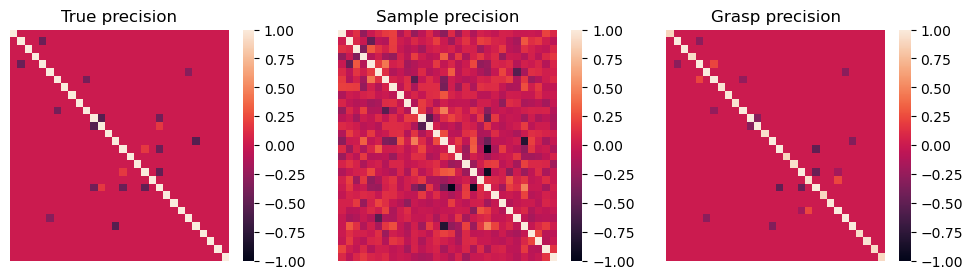

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.heatmap(prec, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('True precision')

sns.heatmap(prec_sample, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Sample precision')

sns.heatmap(prec_, vmin=-1, vmax=1, ax=axes[2])
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Grasp precision')

plt.show()

2. **We consider the graph structure corresponding to a random vector with some variables being AR(1) sequences.**

We use the same method as mentioned above to construct and process the sample.
We define a function that generates a desired symmetric positive definite matrix as follow.

In [7]:
def sparse_spd_matrix(p, s, model=0, u=10, v=1):
    # Create a zero matrix
    matrix = np.zeros((p, p))

    # Set diagonal elements
    np.fill_diagonal(matrix, 1)
    
    if model == 0:
        # Set elements at positions (i-1, i) and (i, i+1)
        np.fill_diagonal(matrix[1:, :s], u)
        np.fill_diagonal(matrix[:s, 1:], u)
    elif model == 1:
        # Set elements at positions (0, i) and (i, 0)
        matrix[0, :s] = u
        matrix[:s, 0] = u

    # Calculate the minimum eigenvalue
    eigenvalues = la.eigvalsh(matrix)
    lambda_min = np.min(eigenvalues)

    if lambda_min < 0:
        # Adjust the matrix if the minimum eigenvalue is less than 0
        adjustment = abs(lambda_min) + v
        matrix += adjustment * np.eye(p)
    matrix *= u
        
    # Check if the matrix is positive definite using Cholesky decomposition
    try:
        cholesky = la.cholesky(matrix)
    except la.LinAlgError:
        raise ValueError("The generated matrix is not positive definite!")

    return matrix

Below, we similarly construct a sample and display the actual network graph corresponding to the sample. 
Then, we use the `GraspSolver` from the `scope` package to process the data in a similar manner. 
We compare the Frobenius norm of the difference between the estimated values and the true values. 
After that, we display the matrix heatmaps of the true precision matrix, the sample precision matrix, and the precision matrix obtained from the estimation.

In [8]:
n, p, s = 150, 30, 10
prec2 = sparse_spd_matrix(p, s, model = 0)
cov = np.linalg.inv(prec2)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec2 *= d
prec2 *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(p), cov, size=n)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# sample covariance and precision matrix
cov_sample2 = np.cov(X.T)
prec_sample2 = np.linalg.inv(cov_sample2)

In [9]:
solver = GraspSolver(
    dimensionality=int(p * (p + 1) / 2),
    sparsity=np.count_nonzero(prec2[np.triu_indices(p)]),
    always_select=np.where(np.triu_indices(p)[0] == np.triu_indices(p)[1])[0],
    numeric_solver=convex_solver_cvxpy,
)

solver.solve(
    graphical_loss,
    cov_sample2,
    init_params=np.eye(p)[np.triu_indices(p)],
)

prec2_ = np.zeros((p, p))
prec2_[np.triu_indices(p)] = solver.params
prec2_ = np.where(
    prec2_, prec2_, prec2_.T
)

In [10]:
print('Grasp: ', np.linalg.norm(prec2 - prec2_, ord='fro'))
print('Empirical: ', np.linalg.norm(prec2 - prec_sample2, ord='fro')) 

Grasp:  6.061625467969832
Empirical:  6.907197094774609


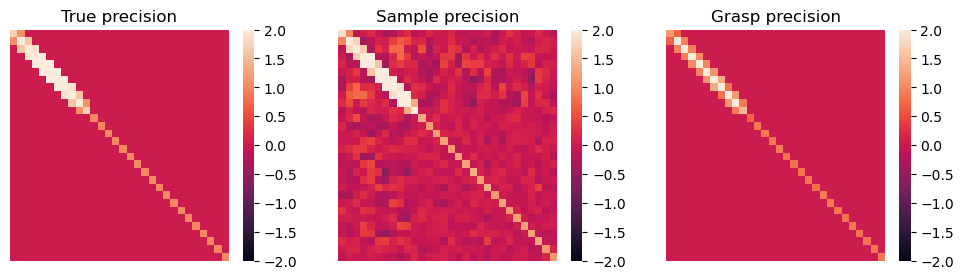

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.heatmap(prec2, vmin=-2, vmax=2, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('True precision')

sns.heatmap(prec_sample2, vmin=-2, vmax=2, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Sample precision')

sns.heatmap(prec2_, vmin=-2, vmax=2, ax=axes[2])
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Grasp precision')

plt.show()

3. **Next, we consider a graph structure that includes a hub node.**

We use the same method as mentioned above to construct and process the sample.

In [12]:
n, p, s = 150, 30, 10
prec3 = sparse_spd_matrix(p, s, model = 1, u=1)
cov = np.linalg.inv(prec3)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec3 *= d
prec3 *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(p), cov, size=n)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# sample covariance and precision matrix
cov_sample3 = np.cov(X.T)
prec_sample3 = np.linalg.inv(cov_sample2)

In [13]:
solver = GraspSolver(
    dimensionality=int(p * (p + 1) / 2),
    sparsity=np.count_nonzero(prec3[np.triu_indices(p)]),
    always_select=np.where(np.triu_indices(p)[0] == np.triu_indices(p)[1])[0],
    numeric_solver=convex_solver_cvxpy,
)

solver.solve(
    graphical_loss,
    cov_sample3,
    init_params=np.eye(p)[np.triu_indices(p)],
)

prec3_ = np.zeros((p, p))
prec3_[np.triu_indices(p)] = solver.params
prec3_ = np.where(
    prec3_, prec3_, prec3_.T
)

In [14]:
print('Grasp: ', np.linalg.norm(prec3 - prec3_, ord='fro'))
print('Empirical: ', np.linalg.norm(prec3 - prec_sample3, ord='fro')) 

Grasp:  1.4386154006817913
Empirical:  15.282896796904431


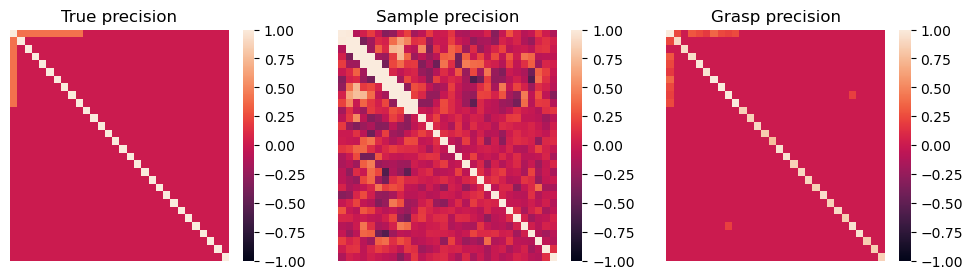

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.heatmap(prec3, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('True precision')

sns.heatmap(prec_sample3, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Sample precision')

sns.heatmap(prec3_, vmin=-1, vmax=1, ax=axes[2])
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Grasp precision')

plt.show()

### Reference

<div id="refer-anchor-1"></div>

- [1] Cai, T., Liu, W., & Luo, X. (2011). A constrained ℓ 1 minimization approach to sparse precision matrix estimation. Journal of the American Statistical Association, 106(494), 594-607.

<div id="refer-anchor-2"></div>

- [2] Bahmani, S., Raj, B., & Boufounos, P. T. (2013). Greedy sparsity-constrained optimization. The Journal of Machine Learning Research, 14(1), 807-841.